# Age Classification Notebook

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, cohen_kappa_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, RobustScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from mord import OrdinalRidge

import matplotlib.pyplot as plt
import seaborn as sns

import shap

In [2]:
model_path = "../data/models/randomforest_age_classifier_gender"
shap_values_path = "../data/shap_values/randomforest_age_classifier_gender"
feature_path = "../data/features.csv"
voices_path = "../data/voices.csv"

In [3]:
features = pd.read_csv(feature_path, index_col="clip_id")
voices = pd.read_csv(voices_path, index_col="clip_id")

In [4]:
# turn 90 and 80 to >= 80
data = voices.merge(features, left_index=True, right_index=True, how='inner')
data.loc[data.voice_age_group == 90, "voice_age_group"] = 80
data.voice_age_group.value_counts()

voice_age_group
20.0    233029
30.0    121920
40.0     70728
50.0     56769
60.0     53183
70.0      7509
80.0       668
Name: count, dtype: int64

In [5]:
data = data.groupby('voice_age_group', group_keys=False).apply(
    lambda x: x.sample(n=2000, replace=True, random_state=42)
).sample(frac=1, random_state=42)
data.voice_age_group.value_counts()

/tmp/ipykernel_3829/1954340304.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('voice_age_group', group_keys=False).apply(


voice_age_group
30.0    2000
60.0    2000
50.0    2000
70.0    2000
40.0    2000
80.0    2000
20.0    2000
Name: count, dtype: int64

In [6]:
data.head()

,audio_file_name,voice_name,voice_age,voice_age_group,voice_gender,features_extracted,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
clip_id,,,,,,,,,,,,,,,,,,,,,
0d8a8786-54d8-470f-b922-5cc459d94e04,common_voice_en_35335742.mp3,30_f_f55a8,NaN,30.0,f,True,33.259449,0.171682,29.235744,32.249416,...,0.057318,0.003839,0.317962,3.742204,2.941177,0.123571,0.078158,0.225833,0.279388,-22.604340
42bfb072-f934-4065-96c9-03dddb6642f5,common_voice_en_32143263.mp3,30_f_a74e4,NaN,30.0,f,True,37.109619,0.206593,32.399002,36.596573,...,0.026710,0.008616,0.123178,1.612903,2.803739,0.163333,0.145736,0.173333,0.193319,-24.661402
17858317-19fc-4062-b799-659cac23f857,common_voice_en_28408076.mp3,60_f_af9c1,NaN,60.0,f,True,32.220005,0.250238,27.960592,30.358505,...,0.041993,0.019698,0.142503,3.296704,2.825553,0.158261,0.127677,0.210526,0.273043,-21.649761
f341a4e5-65c6-4d81-9eb4-3be7b86e9887,common_voice_en_17825976.mp3,30_m_c19bd,NaN,30.0,m,True,33.427921,0.289947,27.610504,29.661760,...,0.092049,0.008741,0.045316,2.358491,0.966184,0.480000,0.250000,0.353333,0.165798,-22.401571
9452f5b8-4c5b-4a02-b53f-c39e607172f2,common_voice_en_23381342.mp3,60_f_7eff9,NaN,60.0,f,True,31.210817,0.110192,29.360758,31.052504,...,0.068632,0.010905,0.017029,3.539823,2.290076,0.193333,0.147761,0.211053,0.370489,-47.665073


In [11]:
data["voice_gender_m"] =  (data.voice_gender == "m") * 1
data[["voice_gender", "voice_gender_m"]]

,voice_gender,voice_gender_m
clip_id,,
0d8a8786-54d8-470f-b922-5cc459d94e04,f,0
42bfb072-f934-4065-96c9-03dddb6642f5,f,0
17858317-19fc-4062-b799-659cac23f857,f,0
f341a4e5-65c6-4d81-9eb4-3be7b86e9887,m,1
9452f5b8-4c5b-4a02-b53f-c39e607172f2,f,0
...,...,...
01c8579e-bf98-45f9-a319-c366a678399f,f,0
399c3921-cde4-4f66-94d0-4b4d579853e3,f,0
4193c71a-2fbc-4bd5-8976-27fdde059f79,f,0


In [17]:
X = data[features.columns.tolist()+["voice_gender_m"]]
y = data.voice_age_group

In [18]:
X.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,voice_gender_m
clip_id,,,,,,,,,,,,,,,,,,,,,
0d8a8786-54d8-470f-b922-5cc459d94e04,33.259449,0.171682,29.235744,32.249416,35.426971,6.191227,192.894608,244.725311,77.038849,63.401012,...,0.003839,0.317962,3.742204,2.941177,0.123571,0.078158,0.225833,0.279388,-22.604340,0
42bfb072-f934-4065-96c9-03dddb6642f5,37.109619,0.206593,32.399002,36.596573,43.073315,10.674313,708.863342,951.328247,608.329956,1164.720093,...,0.008616,0.123178,1.612903,2.803739,0.163333,0.145736,0.173333,0.193319,-24.661402,0
17858317-19fc-4062-b799-659cac23f857,32.220005,0.250238,27.960592,30.358505,33.539734,5.579142,434.908264,450.285278,116.315628,163.251328,...,0.019698,0.142503,3.296704,2.825553,0.158261,0.127677,0.210526,0.273043,-21.649761,0
f341a4e5-65c6-4d81-9eb4-3be7b86e9887,33.427921,0.289947,27.610504,29.661760,49.012127,21.401623,204.223709,159.413849,58.931229,67.356728,...,0.008741,0.045316,2.358491,0.966184,0.480000,0.250000,0.353333,0.165798,-22.401571,1
9452f5b8-4c5b-4a02-b53f-c39e607172f2,31.210817,0.110192,29.360758,31.052504,33.051998,3.691240,499.958832,310.663635,50.943298,50.812332,...,0.010905,0.017029,3.539823,2.290076,0.193333,0.147761,0.211053,0.370489,-47.665073,0


In [19]:
age_bins = [20, 30, 40, 50, 60, 70, 80]
y_ordinal = np.digitize(y, age_bins) - 1

y_ordinal

array([1, 1, 4, ..., 2, 0, 3])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ordinal, test_size=0.2, random_state=42)

In [21]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_classification(model, X_train, X_test, y_train, y_test):
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Probabilities for each class
    y_proba_train = model.predict_proba(X_train)
    y_proba_test = model.predict_proba(X_test)
    
    # Print accuracy scores
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
    
    # Confusion matrix
    conf = confusion_matrix(y_test, y_pred_test)
    print("Confusion Matrix:\n", conf)
    
    # Plot confusion matrix
    sns.heatmap(
        conf,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=age_bins,
        yticklabels=age_bins
    )
    plt.xlabel("Predicted Age Group")
    plt.ylabel("True Age Group")
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curves(model, X_test, y_test):
    # Get predicted probabilities
    y_proba_test = model.predict_proba(X_test)

    # Binarize the output for ROC curve (One-vs-Rest)
    y_test_bin = label_binarize(y_test, classes=np.arange(0, 7))  # Now 0-6
    n_classes = y_test_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_test[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba_test.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    
    # Plot micro-average
    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-average ROC (AUC = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    # Plot macro-average
    plt.plot(fpr["macro"], tpr["macro"],
             label='Macro-average ROC (AUC = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    # Plot individual classes
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='Class {0} (AUC = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves (Labels 0-6)')
    plt.legend(loc="lower right")
    plt.show()

# Ordinal Model

# AT

# Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

ordinal_scorer = make_scorer(cohen_kappa_score, weights='quadratic')

# Best parameters found:  {'max_depth': 10, 'max_features': 0.3, 'min_samples_leaf': 3, 'n_estimators': 600}
param_grid = {
    'n_estimators': [200, 400, 600, 1000],  # More trees help, but with diminishing returns
    'max_depth': [3, 5, 7, 10],  # Control overfitting
    'min_samples_leaf': [3, 5],    # Smooth predictions
    'max_features': ['sqrt', 0.3]  # Reduce correlation between trees
}

model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Use 3-fold CV for speed (increase if you have small datasets)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring=ordinal_scorer,  # Prioritize ordinal agreement
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

model = grid_search.best_estimator_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=200; total time=   4.6s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=200; total time=   4.6s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=200; total time=   4.8s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=200; total time=   4.7s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=200; total time=   5.4s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=400; total time=   9.2s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=400; total time=   9.5s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=400; total time=   9.7s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=3, n_estimators=400; total time=   9.6s
[CV] END max_depth=3, max_features=sqrt, min_samples_lea

In [23]:
from joblib import dump
dump(model, os.path.join(model_path, "randomforest_age_classifier.joblib"))

['../data/models/randomforest_age_classifier_gender/randomforest_age_classifier.joblib']

Train Accuracy: 0.8558928571428571
Test Accuracy: 0.5753571428571429
Confusion Matrix:
 [[153 147  14  26  34  19  15]
 [ 58 194  16  32  48  33   6]
 [ 33  80 185  40  54  26  12]
 [ 31  78  19 177  56  25   6]
 [ 21  43   7  29 267  12  20]
 [ 14  41   7  17  37 259   8]
 [  1  18   1   0   1   4 376]]


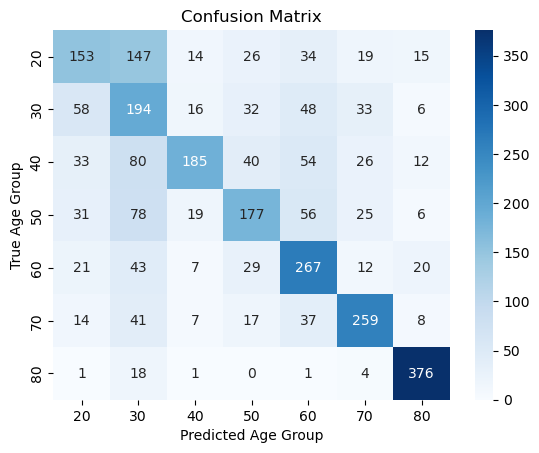

In [24]:
evaluate_model_classification(model, X_train, X_test, y_train, y_test)

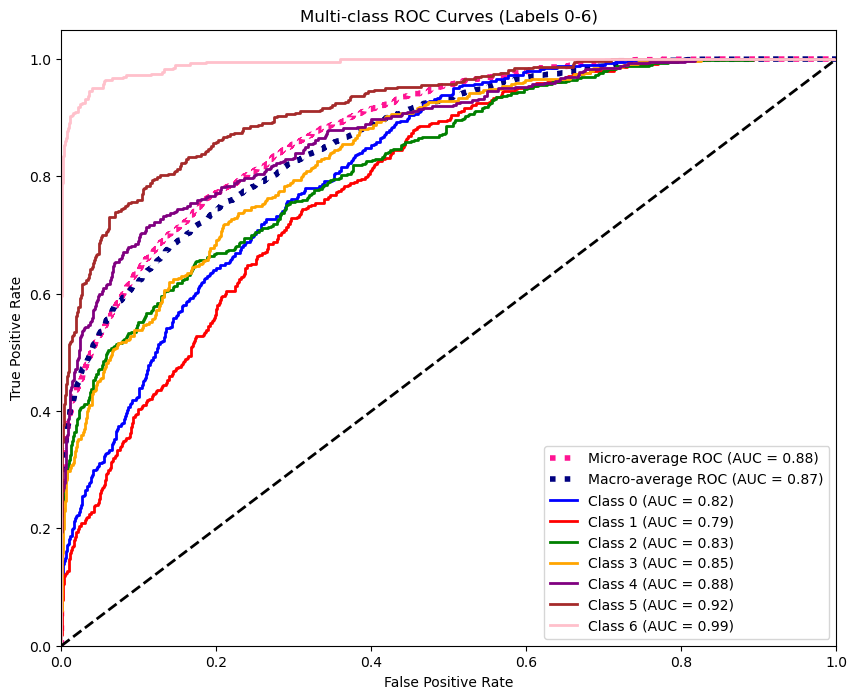

In [25]:
plot_roc_curves(model, X_test, y_test)

# Explainability

In [26]:
tree_explainer = shap.TreeExplainer(model)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test, check_additivity=False)

100%|===================| 19598/19600 [65:32<00:00]        

In [27]:
i = np.random.randint(0, len(X_test))
shap_values_i = tree_explainer.shap_values(X_test.iloc[[i]])
clip_id = X_test.index[i]
true_label = y_test[i]
pred_label = model.predict(X_test.iloc[[i]])[0]
pred_proba = model.predict_proba(X_test.iloc[[i]])[0]

print(f"\nClip ID: {clip_id}")
print(f"True label: {true_label} ({age_bins[true_label]})")
print(f"Predicted: {pred_label} ({age_bins[pred_label]})")
print("Class probabilities:")
for class_idx, prob in enumerate(pred_proba):
    print(f"Class {class_idx}: {prob:.4f}")


Clip ID: 260976c2-facf-4ca9-8de5-42426906c117
True label: 5 (70)
Predicted: 1 (30)
Class probabilities:
Class 0: 0.1155
Class 1: 0.2366
Class 2: 0.1803
Class 3: 0.1494
Class 4: 0.0870
Class 5: 0.1972
Class 6: 0.0339


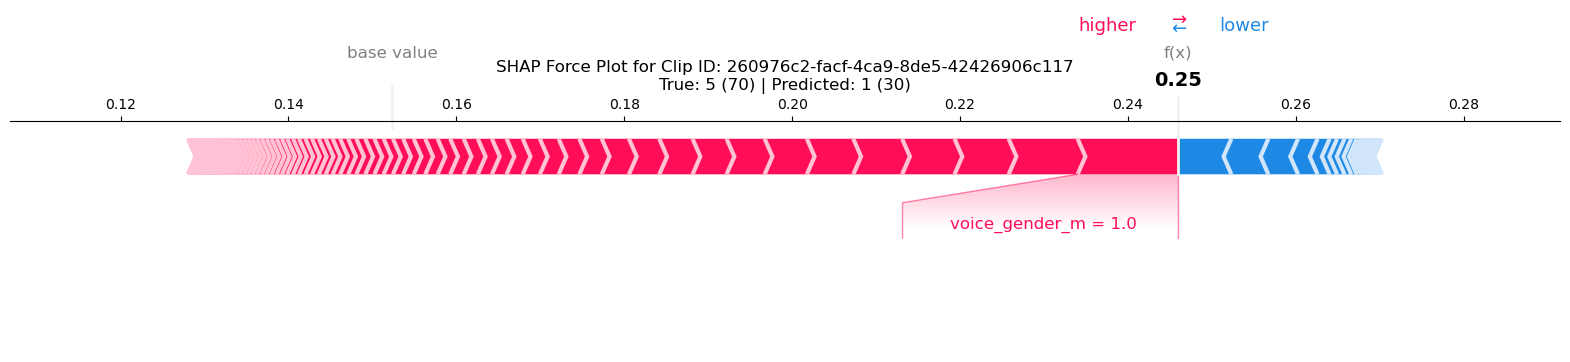

In [28]:
shap.force_plot(
    explainer.expected_value[pred_label],
    shap_values_i[0, :,pred_label],
    X_test.iloc[i,:],
    feature_names=X_test.columns,
    matplotlib=True,
    contribution_threshold=0.08,
    show=False
)
# set range from 0 to 1

plt.title(f"SHAP Force Plot for Clip ID: {clip_id}\nTrue: {true_label} ({age_bins[true_label]}) | Predicted: {pred_label} ({age_bins[pred_label]})")

"""
for class_idx, prob in enumerate(pred_proba):
    shap.force_plot(
        explainer.expected_value[class_idx],
        shap_values_i[:,class_idx],
        X_test.iloc[i,:],
        feature_names=X_test.columns,
        matplotlib=True
    )
"""
plt.show()

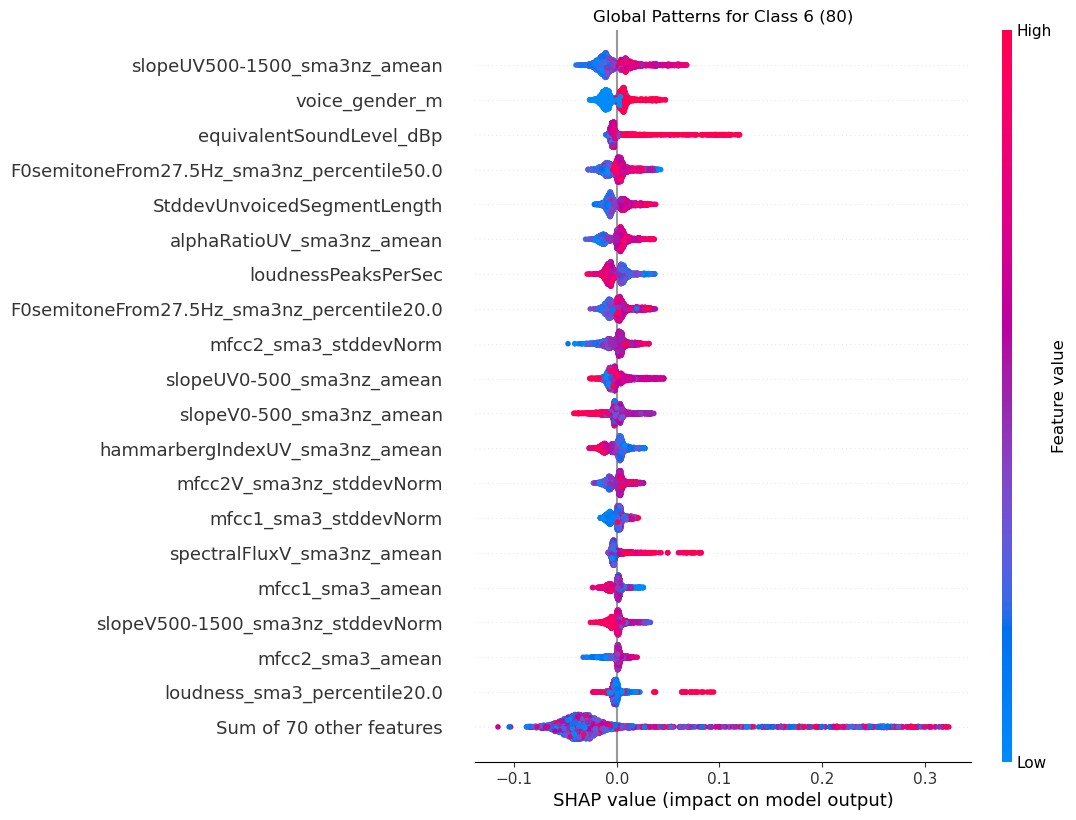

In [29]:
label = 6
shap.plots.beeswarm(shap_values[:, :, label], max_display=20, show=False)
plt.title(f"Global Patterns for Class {label} ({age_bins[label]})")
plt.show()

In [30]:
y_pred = model.predict(X_test)
shap_array = np.stack([sv.values for sv in shap_values]) 

class_shap_dict = {}
for i in range(7):
    class_shap_dict[age_bins[i]] = shap_array[:, :, i].mean(axis=0)

importance_df = pd.DataFrame(class_shap_dict, index=X_test.columns)

In [31]:
importance_df['overall_importance'] = importance_df.abs().mean(axis=1)
top_15_features = importance_df.nlargest(15, 'overall_importance')

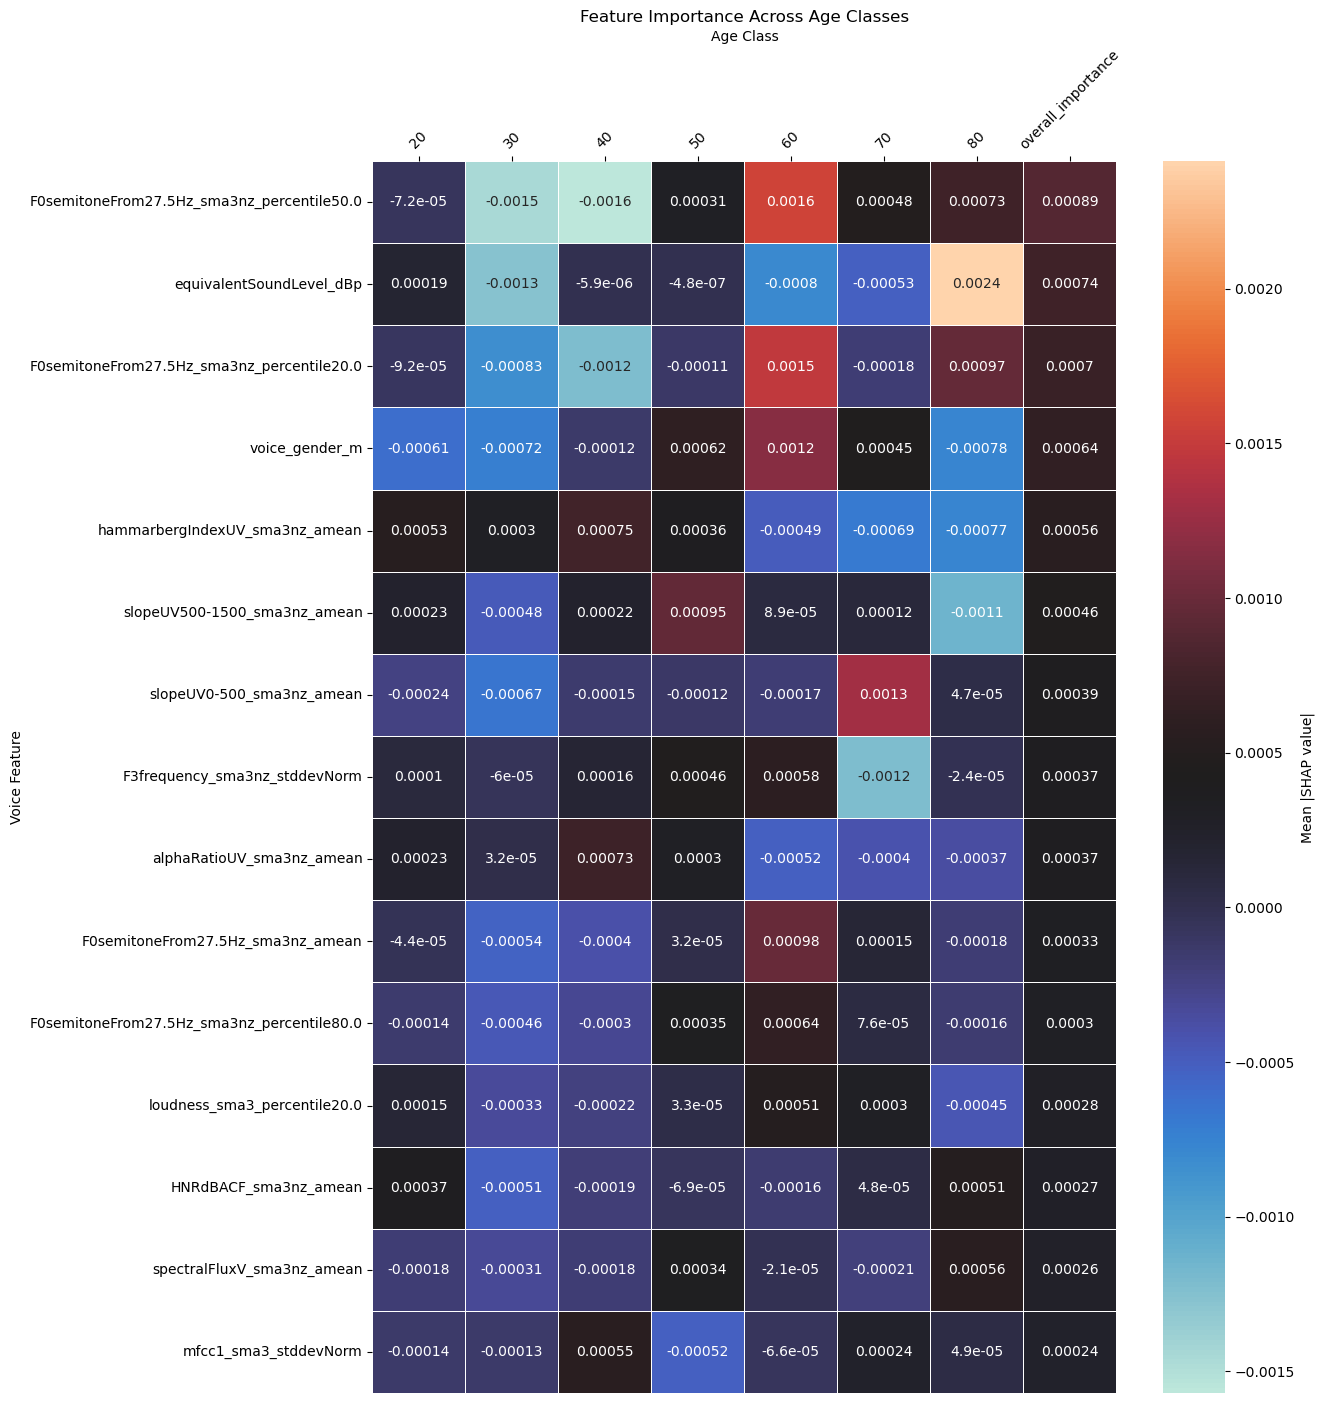

In [32]:
plt.figure(figsize=(12, 16))
ax = sns.heatmap(
    top_15_features,
    cmap="icefire",
    annot=True,
    linewidths=0.5,
    cbar_kws={'label': 'Mean |SHAP value|'},
)
plt.title("Feature Importance Across Age Classes")
ax.xaxis.tick_top()
plt.xticks(rotation=45)
ax.xaxis.set_label_position('top')  
plt.xlabel("Age Class")
plt.ylabel("Voice Feature")
plt.show()

In [33]:
np.save(os.path.join(shap_values_path, "shap_values.npy"), shap_array)
importance_df.to_csv(os.path.join(shap_values_path, "feature_importance.csv"))

In [ ]:
interacion_values = tree_explainer.shap_interaction_values(X_test)